In [3]:
#libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as req
import seaborn as sns 
from sklearn.linear_model import LinearRegression
import scipy.stats 


In [4]:
#Classes to process the data
class State(object):
  def __init__(self, state, new_cases_per_100k, dem_margin):
    self.state = state
    self.cases = new_cases_per_100k
    self.dem_margin = dem_margin
  
  def toString(self):
    return f"State: {self.state}, Average New Weekly Cases Per 100k: {self.cases}, Democratic Margin of Victory: {self.dem_margin}"

#Container class to hold the data
class Container(object):
  def __init__(self):
    self.states = []
  
  def add(self, state):
    self.states.append(state)
  
  def toString(self):
    string = ''
    for item in self.states:
      string += item.toString() + "\n"
    return string

class StateCovidData(object):
  def __init__(self, state):
    self.state = state
    self.cases = 0
    self.point_count = 0
    self.sum_of_cases = 0
  
  def add(self, new_cases_per_100k):
    self.point_count += 1
    self.sum_of_cases += new_cases_per_100k
    self.cases = self.sum_of_cases/self.point_count
    
  def toString(self):
    return f"{self.state}, Average New Weekly Cases Per 100k: {self.cases}"

In [5]:
#Covid Data 
cov_key = "2c3b686a09214915b1471a2f0df00d20"
cov_url = "https://api.covidactnow.org/v2/states.timeseries.csv?apiKey="+cov_key

#Create dataframe
df = pd.read_csv(cov_url)

In [17]:
random_data = df.loc[:, ["date", "state", "actuals.cases"]]

            date state  actuals.cases
1     2020-03-02    AK            NaN
2     2020-03-03    AK            NaN
3     2020-03-04    AK            NaN
4     2020-03-05    AK            NaN
5     2020-03-06    AK            NaN
...          ...   ...            ...
9995  2021-01-16    FL      1556308.0
9996  2021-01-17    FL      1567401.0
9997  2021-01-18    FL      1575403.0
9998  2021-01-19    FL      1585219.0
9999  2021-01-20    FL      1597133.0

[9999 rows x 3 columns]


In [7]:
covid_data = df.loc[:, ["date", "state", "metrics.weeklyCovidAdmissionsPer100k"]]

#Take the average of all the data for each state and add it to a dictionary with the state as the key
state_covid_data = {}

for row in covid_data.iterrows():
  #continue if nan 
  if pd.isna(row[1]["metrics.weeklyCovidAdmissionsPer100k"]):
    continue

  if row[1].state in state_covid_data:
    state_covid_data[row[1].state].add(row[1]["metrics.weeklyCovidAdmissionsPer100k"])
  else:
    state_covid_data[row[1].state] = StateCovidData(row[1].state)
    state_covid_data[row[1].state].add(row[1]["metrics.weeklyCovidAdmissionsPer100k"])


In [8]:

#Voting Data 
vote_data = pd.read_csv(r'../data/pop_vote2.csv')

#Make a dictionary with the states as keys and the democratic margin as values
vote_dict_names = dict(zip(vote_data['state'], vote_data['dem_this_margin']))

#Dict of abbreviations and full names
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
#Reverse the list to use the name to find the variables 
#inv_map = {v: k for k, v in my_map.items()}
state_dict = {v:k for k, v in state_dict.items()}

vote_dict_abbrev = {}

#Rename the states to their abrev
for item in vote_dict_names:
    try:
        abbrev = state_dict[item]
        vote_dict_abbrev[abbrev] = vote_dict_names[item]
    except:
        continue

In [9]:
#Put all the data into a container object
container = Container()

for item in vote_dict_abbrev:
    state_obj = State(state=item, dem_margin=vote_dict_abbrev[item], new_cases_per_100k=state_covid_data[item].cases)
    container.add(state_obj)

In [10]:
#Make a plot for the data 

# Make two arrays, one for the dem_margin_vic and one for the cases 
dem_margin = []
cases_per_100k = []

for item in container.states:
  if item.cases == None: 
    continue
  else: 
    cases_per_100k.append(item.cases)
    dem_margin.append(item.dem_margin)

dem_float_arr = []

for item in dem_margin:
   dem_float_arr.append(float(item.replace("%", "")))


Correlation: -0.5552661290508544, P Value of Correlation: 2.847999683982265e-05


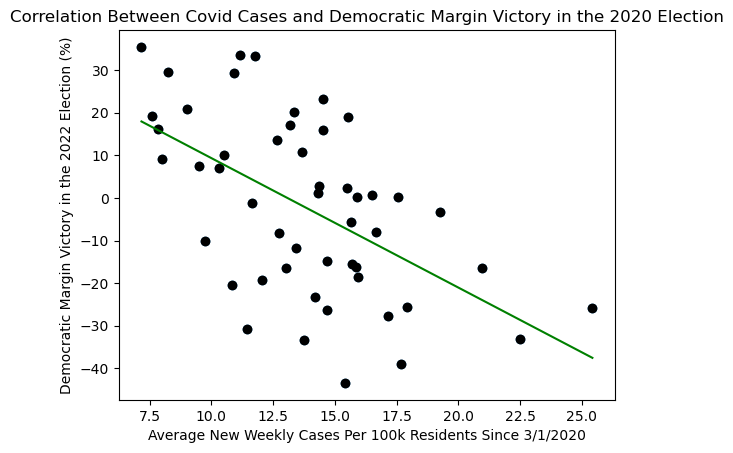

In [11]:
# linear line     
X = pd.DataFrame(cases_per_100k).values
Y = pd.DataFrame(dem_float_arr).values
linear = LinearRegression()
linear.fit(X, Y)
y_pred = linear.predict(X)

plt.figure(0)
plt.scatter(cases_per_100k, dem_float_arr)

# correlation
correlation, p_value_correlation = scipy.stats.pearsonr(cases_per_100k, dem_float_arr)
print(f"Correlation: {correlation}, P Value of Correlation: {p_value_correlation}")

# polyfit of 3rd degree, change the number in the polyfit function to change the degree of fit
fit, cov = np.polyfit(cases_per_100k, dem_float_arr, 1, cov=True)
x_fit = np.linspace(np.min(X),np.max(X))
poly_fit = np.polyval(fit,x_fit)
plt.plot(x_fit, poly_fit, color = 'green')

plt.figure(0)

plt.xlabel("Average New Weekly Cases Per 100k Residents Since 3/1/2020")
plt.ylabel("Democratic Margin Victory in the 2022 Election (%)")
plt.title("Correlation Between Covid Cases and Democratic Margin Victory in the 2020 Election")
plt.scatter(cases_per_100k, dem_float_arr, color='black')
plt.show()